## MNIST(Modified National Institude of Standards and Technology dayabase)
- 데이터 이미지는 28*28, 값은 0-1
  - 2차원 행렬 데이터로 보이지만 실제로는 3차원 데이터 [Channel, Width, Height]
- 레이블은 One-Hot Encoding방식으로 길이가 10인 벡터(e.g) [0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
- CNN(Convolutional Neural Network)사용 예정

In [2]:
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import IPython.display as ipd
from datetime import datetime

def save_fig_with_date(figname):
  plt.savefig(f"{figname}_{datetime.now().strftime('%m_%d_%H_%M_%S')}.png")

In [3]:
# 환경 설정
is_cuda = torch.cuda.is_available()
DEV = torch.device('cuda' if is_cuda else 'cpu')

### MNIST 데이터 불러오기

In [4]:
import torchvision.transforms as transforms
# 평균: 0.5, 표준편차 1.0이 되도록 데이터의 분포(normalize)를 조정
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [5]:
from torchvision.datasets import MNIST
dir_paths = './data/MNIST_DATASET'
trainset = MNIST(dir_paths, transform=mnist_transform, train=True, download=True)
validset = MNIST(dir_paths, transform=mnist_transform, train=False, download=True)
testset = MNIST(dir_paths, transform=mnist_transform, train=False, download=True)

In [6]:
len(trainset), len(validset), len(testset)

(60000, 10000, 10000)

### MNIST 데이터 확인

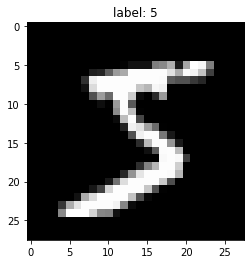

In [86]:
image, label = trainset[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label: %s'%label)
plt.show()

In [103]:
type(image)

torch.Tensor

### Define DataLoader

In [142]:
from torch.utils.data import DataLoader

# 데이터셋을 torch.utils.data.DataLoader에 파라미터로 전달
train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
valid_loader = DataLoader(validset, batch_size=256, shuffle=False, num_workers=0)
test_loader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)

### Define Model

In [184]:
class ClassModel(nn.Module):
    def __init__(self, channels, hidden_size, num_output):
        super().__init__()
        
        self.conv_layer = nn.Sequential(
            # 1, 16
            nn.Conv2d(channels, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(hidden_size, out_channels=hidden_size*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_size*2),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),     
            
            nn.Conv2d(hidden_size*2, out_channels=hidden_size*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_size*4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(), # 7 7 64
        )
        self.final_layer = nn.Linear(7*7*hidden_size*4, num_output)
    
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(out.size(0), -1)
        # out = torch.max(out, dim=-1)[0]
        out = self.final_layer(out)
        out = torch.sigmoid(out)
        return out   

### Train the Network

In [193]:
def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
    loss_records =[] 
    valid_acc_records = []
    model.train() # Set model to train mode
    for epoch in tqdm(range(num_epochs)):
        for batch in train_loader:
          optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
          image, label = batch
          image = image.to(device)
          label = label.to(device)
          pred = model(image)
          loss = loss_func(pred, label)

          loss.backward() # Run backpropagation
          optimizer.step() # Update parameters
          loss_records.append(loss.item())
        valid_acc = validate_model(model, valid_loader, device)
        valid_acc_records.append(valid_acc.item())    
    return {"loss": loss_records, "valid_acc": valid_acc_records}

def validate_model(model, test_loader, device='cuda'):
    model.eval()
    model.to(device)
    valid_acc = 0
    for batch in test_loader:
        data, target = batch
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        pred = output.data.max(1)[1]
        valid_acc += pred.eq(target.data).sum()
    model.train()
    return valid_acc/len(test_loader.dataset)

In [194]:
model = ClassModel(channels=1, hidden_size=16, num_output=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to(DEV)
loss_func = torch.nn.CrossEntropyLoss()
train_record = train_model(model, train_loader, valid_loader, optimizer, num_epochs=30, loss_func=loss_func, device=DEV)

100%|██████████| 30/30 [08:40<00:00, 17.35s/it]


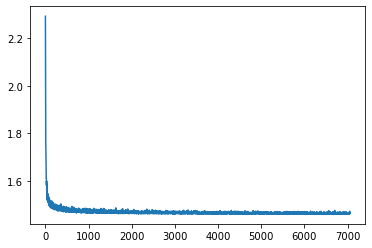

In [195]:
plt.plot(train_record['loss'])
save_fig_with_date('default_train_loss')

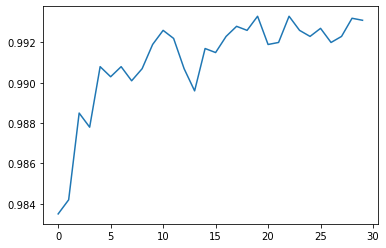

In [196]:
plt.plot(train_record['valid_acc'])
save_fig_with_date('default_train_valid_acc')

In [197]:
max(train_record['valid_acc'])

0.9933000206947327

### save models

In [202]:
torch.save(model.state_dict(), 'mnist.pt')